In [3]:
from utils import *
from fastai2.vision.widgets import *

In [2]:
key = 'XXX'

In [5]:
sport_types = 'baseball','american football','basketball'
path = Path('athletes')

In [4]:
if not path.exists():
    path.mkdir()
    
for o in sport_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} players')
    download_images(dest, urls=results.attrgot('content_url'))

In [6]:
fns = get_image_files(path)
fns

(#466) [Path('athletes/american football/00000000.JPG'),Path('athletes/american football/00000001.JPG'),Path('athletes/american football/00000002.jpg'),Path('athletes/american football/00000003.jpg'),Path('athletes/american football/00000004.jpg'),Path('athletes/american football/00000005.jpg'),Path('athletes/american football/00000006.jpg'),Path('athletes/american football/00000007.jpg'),Path('athletes/american football/00000008.jpg'),Path('athletes/american football/00000009.jpg')...]

Removing failed images:

In [6]:
failed = verify_images(fns)

In [7]:
failed

(#15) [Path('athletes/american football/00000014.jpg'),Path('athletes/american football/00000081.jpeg'),Path('athletes/american football/00000095.jpg'),Path('athletes/american football/00000109.jpg'),Path('athletes/american football/00000139.jpg'),Path('athletes/american football/00000148.jpeg'),Path('athletes/baseball/00000053.jpg'),Path('athletes/baseball/00000105.jpg'),Path('athletes/baseball/00000141.jpg'),Path('athletes/baseball/00000142.jpg')...]

In [8]:
failed.map(Path.unlink)

(#15) [None,None,None,None,None,None,None,None,None,None...]

In [7]:
athletes = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [33]:
dls = athletes.dataloaders(path)

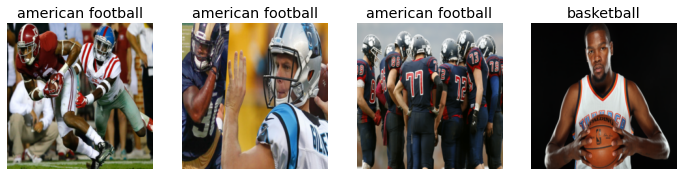

In [34]:
dls.valid.show_batch(max_n=4, nrows=1)

In [35]:
athletes = athletes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = athletes.dataloaders(path, num_workers = 0)

In [36]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.820588,1.050116,0.408602,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.761187,0.365293,0.150538,00:26
1,0.551621,0.186585,0.086022,00:26
2,0.429414,0.153428,0.064516,00:25
3,0.342563,0.151688,0.064516,00:24


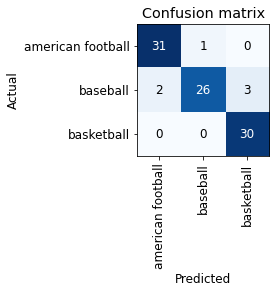

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

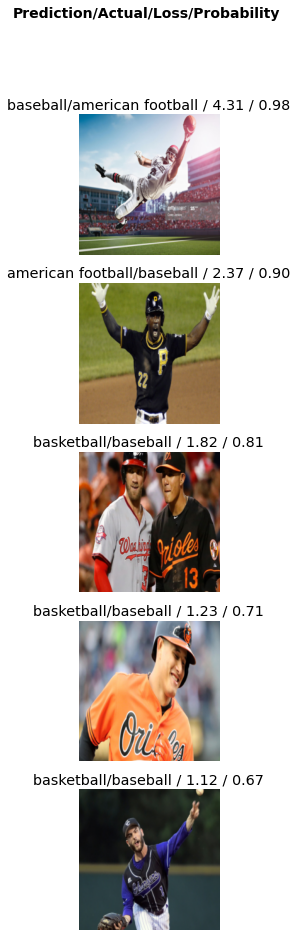

In [38]:
interp.plot_top_losses(5, nrows=5)

In [39]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Retraining:

In [41]:
fns = get_image_files(path)
fns

(#466) [Path('athletes/american football/00000000.JPG'),Path('athletes/american football/00000001.JPG'),Path('athletes/american football/00000002.jpg'),Path('athletes/american football/00000003.jpg'),Path('athletes/american football/00000004.jpg'),Path('athletes/american football/00000005.jpg'),Path('athletes/american football/00000006.jpg'),Path('athletes/american football/00000007.jpg'),Path('athletes/american football/00000008.jpg'),Path('athletes/american football/00000009.jpg')...]

In [8]:
dls = athletes.dataloaders(path)

In [9]:
athletes = athletes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = athletes.dataloaders(path, num_workers = 0)

In [10]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/mc2mc/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.550510,0.626255,0.204301,00:49


/home/mc2mc/anaconda3/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.614653,0.211452,0.075269,00:57
1,0.489848,0.073418,0.021505,00:57
2,0.376803,0.051052,0.021505,00:59
3,0.306541,0.043285,0.021505,00:54


In [11]:
learn.export('athletes_model.pkl')